In [1]:
import numpy as np
from dataloader import get_darcy_data_transformers
import matplotlib.pyplot as plt

from conditioningMaps import build_regression_problem
plt.style.use('ggplot')

# Bring over a copy of data from one of the other darcy datasets

In [9]:
num_train = 2000
num_test = 500
num_observation_grid = 2
noise_level = 0.2
latent_dimension = 10


y_data_full,x_data_full,pca,y_Normalizer = get_darcy_data_transformers(
    latent_dim = latent_dimension,
    num_observation_grid = num_observation_grid,
    noise_level_y_observed = noise_level,
    num_datapoints = num_train + num_test,
    path_prefix = 'data_old_wider_bandwidth'
)

y_data = y_data_full[:num_train]
x_data = x_data_full[:num_train]

y_data_test = y_data_full[num_train:]
x_data_test = x_data_full[num_train:]

Resampling observation arrays


  0%|          | 0/2500 [00:00<?, ?it/s]

In [10]:
def visualize_example(y,x,model,num_samples = 1000):
    example_samples = np.hstack([np.vstack([y]*num_samples),np.random.normal(size = (num_samples,x.shape[0]))])

    predictions = model.predict(example_samples)

    posterior_samples = pca.inverse_transform(predictions)

    posterior_mean = np.mean(posterior_samples,axis=0).reshape(40,40)
    true_solution_PCA = pca.inverse_transform(x).reshape(40,40)
    posterior_variance = np.var(posterior_samples,axis=0).reshape(40,40)

    plt.figure(figsize=(12,12))
    plt.subplot(2,2,1)
    plt.imshow(true_solution_PCA)
    plt.title(f"Original Field after PCA")
    plt.colorbar()

    plt.subplot(2,2,2)
    plt.imshow(posterior_mean)
    plt.title("Posterior Mean from Sampling")
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.imshow((true_solution_PCA - posterior_mean)**2)
    plt.title(f"Squared Error of posterior mean")
    plt.colorbar()

    plt.subplot(2,2,4)
    plt.imshow(posterior_variance)
    plt.title(f"Posterior variance")
    plt.colorbar()
    plt.show()

In [11]:
target = np.hstack([y_data,x_data])

reference_samples = np.random.normal(size = x_data.shape)
reference = np.hstack([y_data,reference_samples])
num_shared_dim = 64

In [12]:
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor

model_kernel = (
    WhiteKernel(noise_level_bounds=(1e-5,2))+
    1.0*RBF(length_scale_bounds=(1e-4,1e4))+
    10*DotProduct()
)

model = GaussianProcessRegressor(kernel=model_kernel)

reg_X,reg_y = build_regression_problem(
    reference,
    target,
    conditioning_eps = 1e-1,
    dim_shared = num_observation_grid**2,
    solver = 'lp'
)

trained_model = model.fit(reg_X,reg_y)

Building Cost Matrix
Solving OT Problem
Finished


In [13]:
trained_model.kernel_

WhiteKernel(noise_level=0.434) + 0.794**2 * RBF(length_scale=5.14) + 0.11**2 * DotProduct(sigma_0=0.0562)

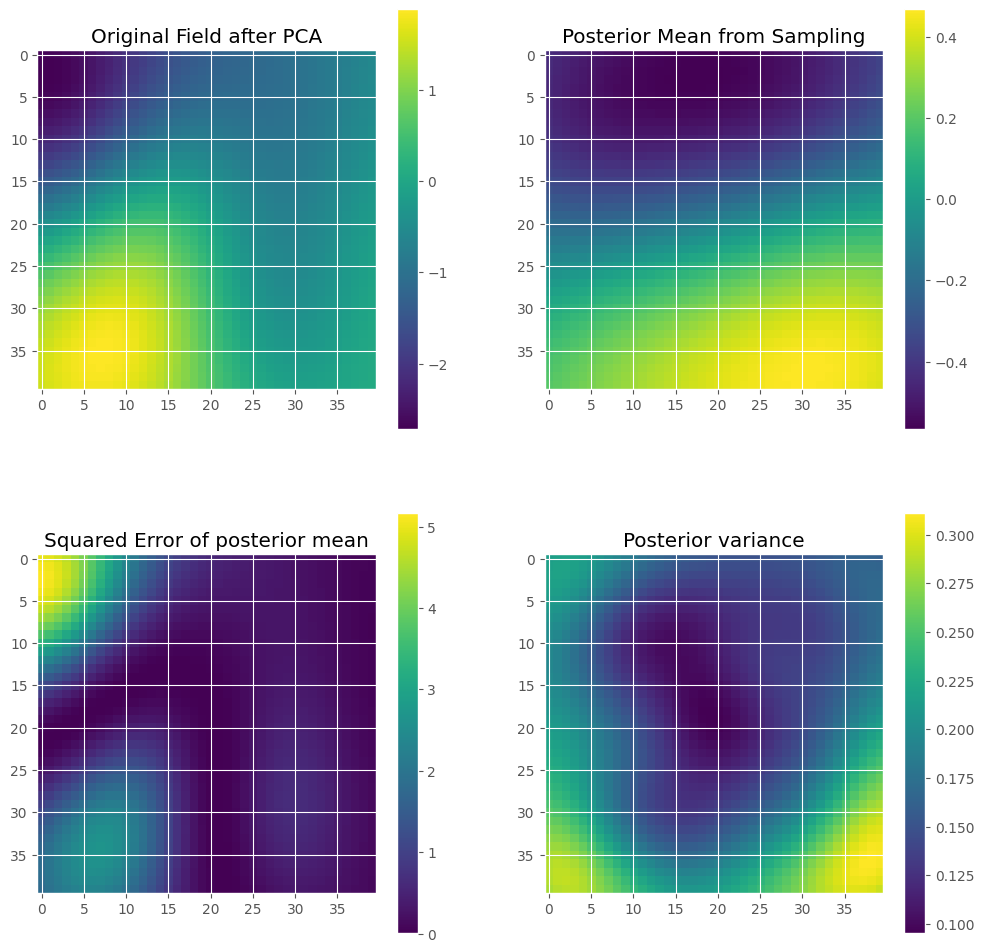

In [14]:
index = 25
visualize_example(y_data_test[index],x_data_test[index],trained_model,num_samples = 100)